In [1]:
# OLD METHODOLOGY, KEEP!!!!
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

class NeuNet(object):       # to the class we shall provide a model, a loss_fn and an optimizer.
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)                                                  # here we send the model to the device

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):                                                           # this is the function sending the model to the device
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):                           # data loaders provide the input data in a sutiable format to the model, in a minibatch size
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()                                                      # the model has a different behaviour during training and evaluation mode

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()                                              # avoid cumulation of gradients

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()                                                       # here we set the model to evaluation mode

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):                                             # this function execute the training of the model
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:                                                         # this is optional, i.e. Tensorboard output
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))                                 # sending input to device
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()                                          # sending back to cpu for return

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b', lw=1)
        plt.plot(self.val_losses, label='Test Loss', c='r', lw=1)
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

# TODO: Set the paths dynamically !!
PATH_MONTECARLO = r"..\jupyter_notebooks\file\output\SimBench\montecarlo_database.csv" 
df_montecarlo = pd.read_csv(PATH_MONTECARLO, sep=",", index_col=[0, 1, 2, 3, 4])# , decimal=",")
column_mapping = {col: i+1 for i, col in enumerate(df_montecarlo.columns)}
timestep_mapping_df = pd.DataFrame(list(column_mapping.items()), columns=['time', 'timestep'])
number_of_iterations = df_montecarlo.index.get_level_values('iteration').max()+1
X_df_montecarlo = df_montecarlo.stack().unstack("id")

PATH_NETWORK = r"..\jupyter_notebooks\file\input\SimBench\network.xlsx" 
df_network = pd.read_excel(PATH_NETWORK, sheet_name="profiles", decimal=",")
df_network = df_network.drop(index=0).reset_index(drop=True)
df_network = df_network.drop(df_network.columns[0], axis=1)
#df_network = df_network.drop(df_network.index[-1]) # Testen ob notwendig.
df_network= df_network.head(df_montecarlo.shape[1])

temp_df = df_network.copy()
arr = temp_df.to_numpy()
arr = arr.astype(np.float64)
df_network = pd.DataFrame(np.tile(arr, (number_of_iterations, 1)), columns = temp_df.columns)

df_network.index= X_df_montecarlo.index
number_of_lines = len(set(X_df_montecarlo.columns))
X_df_montecarlo = pd.concat([X_df_montecarlo, df_network], axis=1)
X_df_montecarlo.insert(0, 'idx', range(1, len(X_df_montecarlo) + 1))
X = X_df_montecarlo.to_numpy()
idx_mapping = X_df_montecarlo.reset_index()
idx_mapping.rename(columns={'level_4': 'timestep'}, inplace=True)
idx_mapping = idx_mapping[['strata', 'iteration', 'timestep', 'idx']]

z = pd.DataFrame(X).iloc[:,1:number_of_lines+1].astype(int).astype(str).agg(''.join, axis=1)
l = []
from collections import Counter
c = Counter(z)
for k in z:
    if c[k] == 1:
        l.append(str('G0'))
    else:
        l.append(str(k))

# TODO make train size a variable available as input
X_train, X_val = train_test_split(X, train_size = 0.1, test_size = 0.1, stratify = pd.DataFrame(l)[0], shuffle = True, random_state = 42)

idx_for_opf = pd.concat([pd.Series(X_train[:, 0]) , pd.Series(X_val[:, 0])])
opfs_timesteps = (
    X_df_montecarlo[X_df_montecarlo['idx'].isin(idx_for_opf)]
    .reset_index()
    .rename(columns={'level_4': 'time'})
    [['iteration', 'time']]
    .merge(timestep_mapping_df, on='time', how='left')
)
df_opf_list = (
    opfs_timesteps.groupby('iteration')['timestep']
    .apply(list)
    .reset_index()
)
df_opf_list['timestep'] = df_opf_list['timestep'].apply(lambda x: [i - 1 for i in x])

PATH_ENGINE = r"..\jupyter_notebooks\file\output\SimBench\engine_database.csv"
df_engine = pd.read_csv(PATH_ENGINE, sep=",", index_col=[0, 1, 2, 3, 4])
y_df = df_engine.loc[:,:,"loss_of_load_p_mw","load",:,:].stack().unstack("id")
ysum_df = pd.DataFrame(y_df.sum(axis=1))
ysum_df = ysum_df.reset_index()
ysum_df.rename(columns={'level_2': 'timestep', 0: 'opf_sum'}, inplace=True)
ysum_df = pd.merge(ysum_df, idx_mapping[['strata', 'iteration', 'timestep', 'idx']], 
                     on=['strata', 'iteration', 'timestep'], 
                     how='left')
Y = ysum_df['opf_sum'].to_numpy().reshape(-1,1)
y_train = pd.merge(pd.Series(X_train[:, 0], name='idx'), ysum_df[['idx', 'opf_sum']], on='idx', how='left')['opf_sum']
y_val = pd.merge(pd.Series(X_val[:, 0], name='idx'), ysum_df[['idx', 'opf_sum']], on='idx', how='left')['opf_sum']

X_TRAIN = X_train[:,1:]
Y_TRAIN = y_train.to_numpy().reshape(-1,1)
X_VAL = X_val[:,1:]
X_VAL_UNSCALED = X_VAL
Y_VAL = y_val.to_numpy().reshape(-1,1)
Y_VAL_UNSCALED = Y_VAL

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_TRAIN = np.concatenate((X_TRAIN.T[:number_of_lines].T, scaler_x.fit_transform(X_TRAIN.T[number_of_lines:].T)), axis=1).astype(float)
X_VAL = np.concatenate((X_VAL.T[:number_of_lines].T, scaler_x.transform(X_VAL.T[number_of_lines:].T)), axis=1).astype(float)# without fit!
Y_TRAIN = scaler_y.fit_transform(Y_TRAIN).astype(float)
Y_VAL = scaler_y.transform(Y_VAL).astype(float)


In [2]:
from reXplan import ml as rxml
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

class NeuNet(object):       # to the class we shall provide a model, a loss_fn and an optimizer.
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)                                                  # here we send the model to the device

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):                                                           # this is the function sending the model to the device
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):                           # data loaders provide the input data in a sutiable format to the model, in a minibatch size
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()                                                      # the model has a different behaviour during training and evaluation mode

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()                                              # avoid cumulation of gradients

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()                                                       # here we set the model to evaluation mode

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):                                             # this function execute the training of the model
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:                                                         # this is optional, i.e. Tensorboard output
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))                                 # sending input to device
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()                                          # sending back to cpu for return

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b', lw=1)
        #plt.plot(self.val_losses, label='Test Loss', c='r', lw=1)
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))


PATH_MONTECARLO = r"..\jupyter_notebooks\file\output\SimBench\montecarlo_database.csv" 
df_montecarlo = pd.read_csv(PATH_MONTECARLO, sep=",", index_col=[0, 1, 2, 3, 4])# , decimal=",")
column_mapping = {col: i+1 for i, col in enumerate(df_montecarlo.columns)}
timestep_mapping_df = pd.DataFrame(list(column_mapping.items()), columns=['time', 'timestep'])
number_of_iterations = df_montecarlo.index.get_level_values('iteration').max()+1
X_df_montecarlo = df_montecarlo.stack().unstack("id")

PATH_NETWORK = r"..\jupyter_notebooks\file\input\SimBench\network.xlsx" 
df_network = pd.read_excel(PATH_NETWORK, sheet_name="profiles", decimal=",")
df_network = df_network.drop(index=0).reset_index(drop=True)
df_network = df_network.drop(df_network.columns[0], axis=1)
#df_network = df_network.drop(df_network.index[-1]) # Testen ob notwendig.
df_network= df_network.head(df_montecarlo.shape[1])

temp_df = df_network.copy()
arr = temp_df.to_numpy()
arr = arr.astype(np.float64)
df_network = pd.DataFrame(np.tile(arr, (number_of_iterations, 1)), columns = temp_df.columns)

df_network.index= X_df_montecarlo.index
number_of_lines = len(set(X_df_montecarlo.columns))
X_df_montecarlo = pd.concat([X_df_montecarlo, df_network], axis=1)
X_df_montecarlo.insert(0, 'idx', range(1, len(X_df_montecarlo) + 1))
X = X_df_montecarlo.to_numpy()
idx_mapping = X_df_montecarlo.reset_index()
idx_mapping.rename(columns={'level_4': 'timestep'}, inplace=True)
idx_mapping = idx_mapping[['strata', 'iteration', 'timestep', 'idx']]

z = pd.DataFrame(X).iloc[:,1:number_of_lines+1].astype(int).astype(str).agg(''.join, axis=1)
l = []
from collections import Counter
c = Counter(z)
for k in z:
    if c[k] == 1:
        l.append(str('G0'))
    else:
        l.append(str(k))

X_train, X_val = train_test_split(X, train_size = 0.10, test_size = 0.10, stratify = pd.DataFrame(l)[0], shuffle = True, random_state = 42)

idx_for_opf = pd.concat([pd.Series(X_train[:, 0]) , pd.Series(X_val[:, 0])])
opfs_timesteps = (
    X_df_montecarlo[X_df_montecarlo['idx'].isin(idx_for_opf)]
    .reset_index()
    .rename(columns={'level_4': 'time'})
    [['iteration', 'time']]
    .merge(timestep_mapping_df, on='time', how='left')
)
df_opf_list = (
    opfs_timesteps.groupby('iteration')['timestep']
    .apply(list)
    .reset_index()
)
df_opf_list['timestep'] = df_opf_list['timestep'].apply(lambda x: [i - 1 for i in x])

PATH_ENGINE = r"..\jupyter_notebooks\file\output\SimBench\engine_database.csv"
df_engine = pd.read_csv(PATH_ENGINE, sep=",", index_col=[0, 1, 2, 3, 4])
y_df = df_engine.loc[:,:,"loss_of_load_p_mw","load",:,:].stack().unstack("id")
ysum_df = pd.DataFrame(y_df.sum(axis=1))
ysum_df = ysum_df.reset_index()
ysum_df.rename(columns={'level_2': 'timestep', 0: 'opf_sum'}, inplace=True)
ysum_df = pd.merge(ysum_df, idx_mapping[['strata', 'iteration', 'timestep', 'idx']], 
                     on=['strata', 'iteration', 'timestep'], 
                     how='left')
Y = ysum_df['opf_sum'].to_numpy().reshape(-1,1)
y_train = pd.merge(pd.Series(X_train[:, 0], name='idx'), ysum_df[['idx', 'opf_sum']], on='idx', how='left')['opf_sum']
y_val = pd.merge(pd.Series(X_val[:, 0], name='idx'), ysum_df[['idx', 'opf_sum']], on='idx', how='left')['opf_sum']

X_TRAIN = X_train[:,1:]
Y_TRAIN = y_train.to_numpy().reshape(-1,1)


X_VAL = X_val[:,1:]
X_VAL_UNSCALED = X_VAL
Y_VAL = y_val.to_numpy().reshape(-1,1)
Y_VAL_UNSCALED = Y_VAL

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_TRAIN = np.concatenate((X_TRAIN.T[:number_of_lines].T, scaler_x.fit_transform(X_TRAIN.T[number_of_lines:].T)), axis=1).astype(float)
Y_TRAIN = scaler_y.fit_transform(Y_TRAIN).astype(float)

## Model Preparation - ORIGINAL

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(555)

# Builds tensors from numpy arrays BEFORE split
X_train_tensor = torch.from_numpy(X_TRAIN).float()
X_val_tensor = torch.from_numpy(X_VAL).float()
y_train_tensor = torch.from_numpy(Y_TRAIN).float()
y_val_tensor = torch.from_numpy(Y_VAL).float()

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = []
val_loader = []
   
train_loader.append(DataLoader(dataset=dataset_train, batch_size=256, shuffle=True)) #batch_size=256
val_loader.append(DataLoader(dataset=dataset_val, batch_size=256))
print(X_train_tensor.shape)
print(X_val_tensor.shape)
print(y_train_tensor.shape)
print(y_val_tensor.shape)

torch.Size([1200, 195])
torch.Size([1200, 195])
torch.Size([1200, 1])
torch.Size([1200, 1])


## Model Configuration

In [3]:
#%%writefile ./v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.001

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(X_TRAIN.shape[1], 512), nn.ReLU(),
                      #nn.Dropout(p=0.1),
                      nn.Linear(512, 512), nn.ReLU(),
                      nn.Linear(512, 512), nn.ReLU(),
                      nn.Linear(512,512), nn.ReLU(),
                      nn.Linear(512, 256), nn.ReLU(),
                      nn.Linear(256, Y_TRAIN.shape[1]) ).to(device)

# Defines an  optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

## Model Instantiation

In [4]:
neunet = NeuNet(model, loss_fn, optimizer)
neunet.set_loaders(train_loader[0], val_loader[0])
neunet.set_tensorboard(name="runs", folder = 'machine_learning_tutorial/Test_Grid10')

In [5]:
print(neunet.model)

Sequential(
  (0): Linear(in_features=195, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=1, bias=True)
)


## Model Training

100%|██████████| 180/180 [00:22<00:00,  7.94it/s]


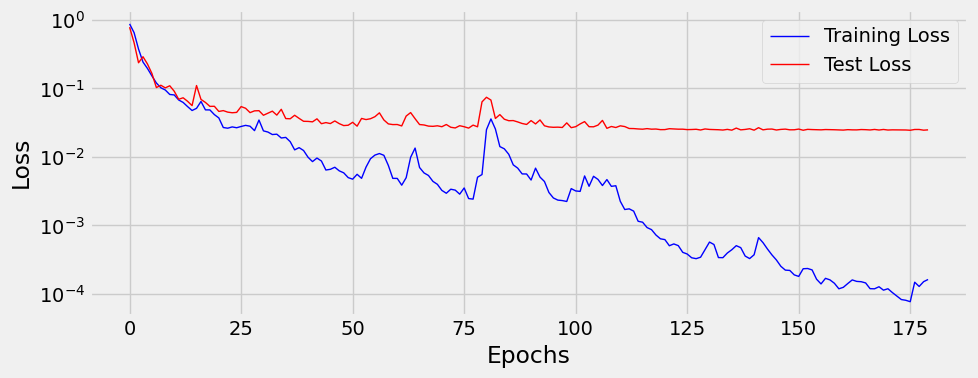

In [6]:
neunet.train(n_epochs = 180)
plt.style.use('fivethirtyeight')
fig = neunet.plot_losses()

In [7]:
print(neunet.val_losses[-1])
print(neunet.losses[-1])

0.02480892613530159
0.00016327038028975948


## TensorBoard

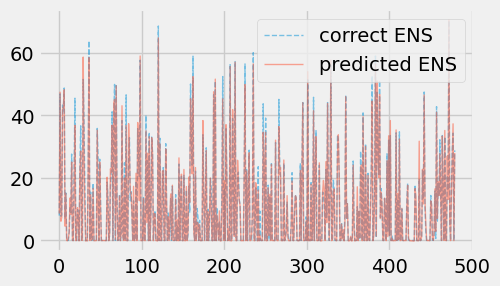

MSE = 0.06890902132241723
Normalized MSE = 0.0009815420017085471
ENSError = 0.02265909199927528


In [8]:
# prediction of validation points
i = 0
start_t = 50
end_t = start_t + 24*4*5
#new_inputs = torch.tensor(X_val).float()
new_inputs = np.array(X_VAL)
model.eval()
#pred = model(new_inputs.to(device))
pred = neunet.predict(new_inputs)
orig = Y_VAL
f, (ax) = plt.subplots(1,1, figsize=(5, 3)) 
plt.plot(scaler_y.inverse_transform(orig)[start_t:end_t, i], alpha=.5, linestyle="--", label="correct ENS", lw=1)
plt.plot(scaler_y.inverse_transform(pred)[start_t:end_t, i], alpha=.5, linestyle="-", label="predicted ENS", lw=1)
plt.legend()
plt.show()
MSE = np.mean(scaler_y.inverse_transform(orig)- scaler_y.inverse_transform(pred))**2
print(f"MSE = {MSE}")
print(f"Normalized MSE = {MSE/(scaler_y.inverse_transform(orig).max()-scaler_y.inverse_transform(orig).min())}")
print(f"ENSError = {abs((scaler_y.inverse_transform(pred).mean() - scaler_y.inverse_transform(orig).mean()))/scaler_y.inverse_transform(orig).mean()}")

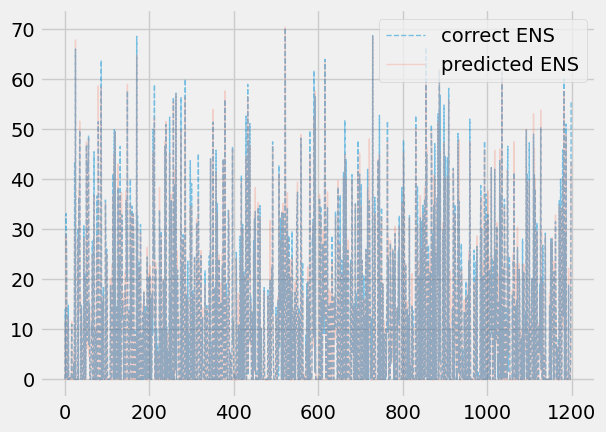

MSE = 0.06890902132241723
MSEP = 0.005948141400826532
ENSError = 0.02265909199927528


In [9]:
# TODO WHAT IS HAPPENING HERE?
#f, (ax) = plt.subplots(1,1, figsize=(5, 3)) 
new_inputs = np.concatenate((X_VAL_UNSCALED.T[:number_of_lines].T, scaler_x.transform(X_VAL_UNSCALED.T[number_of_lines:].T)), axis=1).astype(float)

model.eval()
pred = neunet.predict(new_inputs)
orig = Y_VAL
plt.plot(scaler_y.inverse_transform(orig), alpha=.5, linestyle="--", label="correct ENS", lw=1)
plt.plot(scaler_y.inverse_transform(pred), alpha=.2, linestyle="-", label="predicted ENS", lw=1)
plt.legend()
plt.show()
print(f"MSE = {np.mean(scaler_y.inverse_transform(orig)- scaler_y.inverse_transform(pred))**2}")
print(f"MSEP = {(np.mean(scaler_y.inverse_transform(orig)- scaler_y.inverse_transform(pred))**2)/np.mean(scaler_y.inverse_transform(orig))}")
print(f"ENSError = {abs((scaler_y.inverse_transform(pred).mean() - scaler_y.inverse_transform(orig).mean()))/scaler_y.inverse_transform(orig).mean()}")

ABCHECKEN WARUM Y-AXIS SO KURZ ??? SKALIERTE WERTE GENOMMEN??

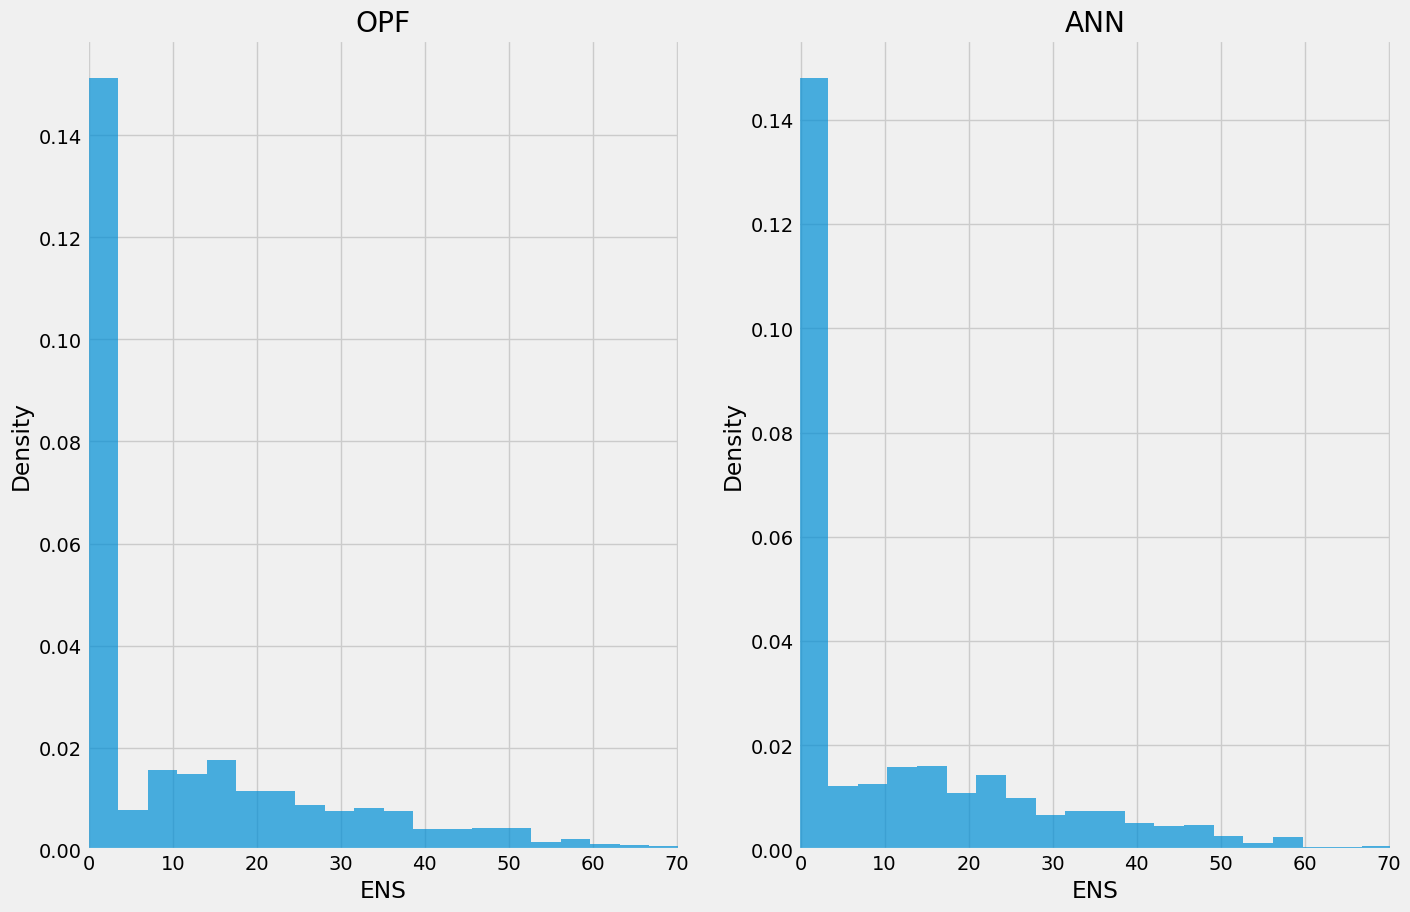

In [10]:
# COMPARISON SCRIPT, KEEP!
from scipy.stats import bootstrap
B_ENS = 1000
# ENSp = np.full((int(len(Y_VAL_UNSCALED)), 1), np.nan)
# ENSo = np.full((int(len(Y_VAL_UNSCALED)), 1), np.nan)
###
##
#
# for i, k in enumerate(range(0, len(Y_VAL_UNSCALED), 1), start=0):
#     ENSp[i] = scaler_y.inverse_transform(pred[k:(k+1)])#.sum()
#     ENSo[i] = scaler_y.inverse_transform(orig[k:(k+1)])#.sum()

ENSp = scaler_y.inverse_transform(pred)
ENSo = scaler_y.inverse_transform(orig)
#
##
###
res_ens_p = bootstrap((ENSp,), np.mean, n_resamples = B_ENS, axis = 0)
res_ens_o = bootstrap((ENSo,), np.mean, n_resamples = B_ENS, axis = 0)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
ax1.set_xlim(min(np.concatenate([ENSo, ENSp])), max(np.concatenate([ENSo, ENSp])))
# ax1.set_ylim(0, 100)
# ax2.set_ylim(0, 100)
ax2.set_xlim(min(np.concatenate([ENSo, ENSp])), max(np.concatenate([ENSo, ENSp])))
#ax1.set_ylim([ymin, ymax])
ax1.hist(ENSo, alpha = 0.7, bins = 20, density=True)
ax1.set_xlabel("ENS")
ax1.set_ylabel("Density")
ax1.set_title("OPF")
ax2.hist(ENSp, alpha = 0.7, bins = 20, density=True)
ax2.set_xlabel("ENS")
ax2.set_ylabel("Density")
ax2.set_title("ANN")
plt.show()

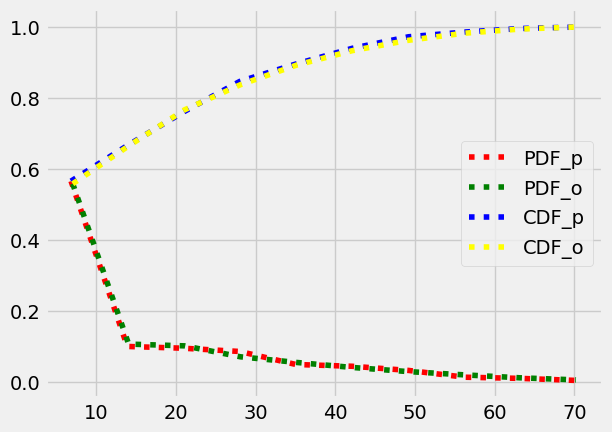

In [11]:
count_p, bins_count_p = np.histogram(ENSp[:,0], bins=10) 
pdf_p = count_p / sum(count_p) 
cdf_p = np.cumsum(pdf_p)

count_o, bins_count_o = np.histogram(ENSo[:,0], bins=10) 
pdf_o = count_o / sum(count_o) 
cdf_o = np.cumsum(pdf_o)
  
plt.plot(bins_count_p[1:], pdf_p, color="red", label="PDF_p", linestyle=':')
plt.plot(bins_count_o[1:], pdf_o, color="green", label="PDF_o", linestyle=':') 
plt.plot(bins_count_p[1:], cdf_p, color="blue", label="CDF_p", linestyle=':')
plt.plot(bins_count_o[1:], cdf_o, color="yellow", label="CDF_o", linestyle=':') 
plt.legend() 

In [12]:
import scipy.stats as ss
ss.kstest(ENSp[ENSp > 1], ENSp[ENSo > 1])

KstestResult(statistic=0.019834710743801654, pvalue=0.9997779983611591, statistic_location=0.9861553, statistic_sign=-1)

In [13]:
import scipy.stats as ss
ss.kstest(ENSp[ENSp > 50], ENSp[ENSo > 50])

KstestResult(statistic=0.3333333333333333, pvalue=0.035081795322097035, statistic_location=49.796864, statistic_sign=-1)

In [14]:
print(res_ens_o.confidence_interval.high)
print(res_ens_o.confidence_interval.low)

[12.45025788]
[10.61655506]


In [15]:
from scipy.stats import kurtosis, skew
print(f"mean ENS predicted = {ENSp.mean()}")
print(f"mean ENS original = {ENSo.mean()}")
print(f"median ENS predicted = {np.median(ENSp)}")
print(f"median ENS original = {np.median(ENSo)}")
print(f"standard deviation ENS predicted = {ENSp.std()}")
print(f"standard deviation ENS original = {ENSo.std()}")
print(f"kurtosis ENS predicted: {kurtosis(ENSp)}")
print(f"kurtosis ENS original: {kurtosis(ENSo)}")
print(f"skeweness ENS predicted: {skew(ENSp)}")
print(f"skeweness ENS original: {skew(ENSo)}")

mean ENS predicted = 11.32246208190918
mean ENS original = 11.584966912999393
median ENS predicted = 1.236086130142212
median ENS original = 1.3742755416964876
standard deviation ENS predicted = 15.317943572998047
standard deviation ENS original = 15.736212133135513
kurtosis ENS predicted: [0.9589231]
kurtosis ENS original: [1.02307978]
skeweness ENS predicted: [1.3327453]
skeweness ENS original: [1.35578422]


## Survivability

In [16]:
X_TRAIN_VAL = np.concatenate((X_TRAIN, X_VAL))
Y_TRAIN_VAL = np.concatenate((Y_TRAIN, Y_VAL))
new_inputs = np.concatenate((X_TRAIN_VAL.T[:number_of_lines].T, scaler_x.transform(X_TRAIN_VAL.T[number_of_lines:].T)), axis=1).astype(float)
model.eval()
pred = neunet.predict(new_inputs)
orig = scaler_y.transform(Y_TRAIN_VAL)

In [17]:

def surv(data):
    out = (data < c).sum()/len(data)
    return(out)
B = 100 # number of bootstraps
MaxLoad = pd.DataFrame(X_TRAIN_VAL).iloc[:,74:].sum(axis=1).max()
crit_load_pu = np.linspace(0,0.45,100)
crit_load = crit_load_pu*MaxLoad
Sp = []
So = []

##########################################################
###
for i, k in enumerate(range(0, len(X_TRAIN_VAL), 1), start=0):
    Sp.append(scaler_y.inverse_transform(pred).T[0])
    So.append(scaler_y.inverse_transform(orig).T[0])
Sp = np.array(Sp)
So = np.array(So)
###
##########################################################
# Sp = scaler_y.inverse_transform(pred).T[0]
# So = scaler_y.inverse_transform(orig).T[0]

q = 1
d_p = (np.quantile(Sp, q, axis=1),)
d_o = (np.quantile(So, q, axis=1),)

q = 1 # quantile deciding the maximum loss of load
#df.iloc[:,5:][(df.type == "load") & (df.field == "max_p_mw")].sum(axis=1).max() # max load
surv_p = np.full(len(crit_load), np.nan)
surv_o = np.full(len(crit_load), np.nan)
surv_p_95H = np.full(len(crit_load), np.nan)
surv_p_95L = np.full(len(crit_load), np.nan)
surv_o_95H = np.full(len(crit_load), np.nan)
surv_o_95L = np.full(len(crit_load), np.nan)

for i, c in enumerate(crit_load):
    surv_p[i] = (np.quantile(Sp, q) < c).sum()/len(Sp)
    surv_o[i] = (np.quantile(So, q) < c).sum()/len(So)

    res_p = bootstrap(d_p, surv, n_resamples = B, axis = 0)
    res_o = bootstrap(d_o, surv, n_resamples = B, axis = 0)
    surv_p_95H[i] = res_p.confidence_interval.high
    surv_p_95L[i] = res_p.confidence_interval.low
    surv_o_95H[i] = res_o.confidence_interval.high
    surv_o_95L[i] = res_o.confidence_interval.low

c:\Users\MN6461\OneDrive - ENGIE\Dokumente\GitHub\reXplan-repo\venv\lib\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Users\MN6461\OneDrive - ENGIE\Dokumente\GitHub\reXplan-repo\venv\lib\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


In [32]:
MaxLoad = df_network.iloc[:,42:].sum(axis=1).max()
#MaxLoad = 173.54 #MW (from analysed time series)
crit_load_pu = np.linspace(0,0.45,100)
crit_load = crit_load_pu*MaxLoad
Sp = []
So = []
for i, k in enumerate(range(0, len(X_TRAIN), 1), start=0):
    #print(k)
    Sp.append(scaler_y.inverse_transform(pred[k:(k+50)]).T[0])
    So.append(scaler_y.inverse_transform(orig[k:(k+50)]).T[0])
Sp = np.array(Sp)
So = np.array(So)

q = 0.1 # quantile deciding the maximum loss of load
#df.iloc[:,5:][(df.type == "load") & (df.field == "max_p_mw")].sum(axis=1).max() # max load
surv_p = np.full(len(crit_load), np.nan)
surv_o = np.full(len(crit_load), np.nan)
for i, c in enumerate(crit_load):
    #surv_p[i] = (Sp.max(axis=1) < c).sum()/240
    surv_p[i] = (np.quantile(Sp, q, axis=1) < c).sum()/240
    #surv_o[i] = (So.max(axis=1) < c).sum()/240
    surv_o[i] = (np.quantile(So, q, axis=1) < c).sum()/240

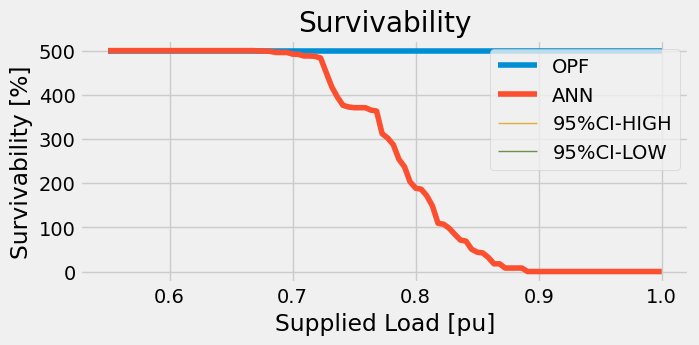

In [35]:
#plt.plot((1-crit_load_pu), surv)
f, (ax1) = plt.subplots(1,1, figsize=(7, 3))
ax1.plot((1-crit_load_pu), surv_o*100)
ax1.set_xlabel("Supplied Load [pu]")
ax1.set_ylabel("Survivability [%]")
ax1.set_title("Survivability")
ax1.plot((1-crit_load_pu), surv_p*100)
ax1.plot((1-crit_load_pu), surv_o_95H*100, linewidth=1)
ax1.plot((1-crit_load_pu), surv_o_95L*100, linewidth=1)
ax1.legend(["OPF", "ANN", "95%CI-HIGH", "95%CI-LOW"], loc ="upper right")
plt.show()

## Checkpointing

In [23]:
neunet.save_checkpoint('model_checkpoint.pth')

## Resuming Training

In [24]:
#%run -i ./v0.py
#%run -i ./v3.py

In [ ]:
print(model.state_dict())

In [26]:
new_neunet = NeuNet(model, loss_fn, optimizer)

In [27]:
new_neunet.load_checkpoint("model_checkpoint.pth")

In [ ]:
print(model.state_dict())

In [ ]:
new_neunet.set_loaders(train_loader[0], val_loader[0])
new_neunet.train(n_epochs=10)

### Plot losses of resumed model

In [ ]:
fig = new_neunet.plot_losses()